## 1.DataSet: Bounding Box

> 1.Store Image and Image Mask GT path instead of loading it to the notebook to avoid RAM Crash

> 2.Extract the bounding box of an object in the image by utilizing the images Mask GT

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub

# 1. Download Dataset
path = kagglehub.dataset_download("crowww/a-large-scale-fish-dataset")
base_dir = os.path.join(path, "Fish_Dataset", "Fish_Dataset")

print(f"Dataset downloaded to: {base_dir}")

# 2. Initialize list to store metadata
dataset_records = []

# 3. Iterate through folders
print("Processing metadata and bounding boxes...")

for species in os.listdir(base_dir):
    species_path = os.path.join(base_dir, species)

    # Check if it's a directory
    if not os.path.isdir(species_path):
        continue

    # The dataset structure  has two folders per species:
    # 1. "SpeciesName" (Images)
    # 2. "SpeciesName GT" (Masks)

    image_folder = os.path.join(species_path, species)
    gt_folder = os.path.join(species_path, f"{species} GT")

    # Ensure both exist
    if not os.path.exists(image_folder) or not os.path.exists(gt_folder):
        continue

    # Loop through images in the image folder
    for img_file in os.listdir(image_folder):
        if img_file.lower().endswith((".png", ".jpg", ".jpeg")):

            # Define Paths
            img_path = os.path.join(image_folder, img_file)
            mask_path = os.path.join(gt_folder, img_file)


            # If exact match not found, check extension variants if necessary.
            if not os.path.exists(mask_path):
                # Try replacing extension if needed, usually this dataset matches names
                continue

            # OPTIMIZATION: OPEN MASK JUST TO GET BOX THEN DISCARD
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Calculate Bounding Box
            ys, xs = np.where(mask > 0)
            if len(xs) > 0:
                xmin, xmax = xs.min(), xs.max()
                ymin, ymax = ys.min(), ys.max()
                # Store metadata
                dataset_records.append({
                    'species': species,
                    'image_path': img_path,
                    'mask_path': mask_path,
                    'xmin': xmin, 'ymin': ymin,
                    'xmax': xmax, 'ymax': ymax,
                    'has_fish': True
                })
            else:
                # Empty mask (no fish in image)
                dataset_records.append({
                    'species': species,
                    'image_path': img_path,
                    'mask_path': mask_path,
                    'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0,
                    'has_fish': False
                })

# 4. Convert to DataFrame
df = pd.DataFrame(dataset_records)

print("--- Processing Complete ---")
print(f"Total images processed: {len(df)}")
print(df.head())

Using Colab cache for faster access to the 'a-large-scale-fish-dataset' dataset.
Dataset downloaded to: /kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset
Processing metadata and bounding boxes...
--- Processing Complete ---
Total images processed: 9000
           species                                         image_path  \
0  Hourse Mackerel  /kaggle/input/a-large-scale-fish-dataset/Fish_...   
1  Hourse Mackerel  /kaggle/input/a-large-scale-fish-dataset/Fish_...   
2  Hourse Mackerel  /kaggle/input/a-large-scale-fish-dataset/Fish_...   
3  Hourse Mackerel  /kaggle/input/a-large-scale-fish-dataset/Fish_...   
4  Hourse Mackerel  /kaggle/input/a-large-scale-fish-dataset/Fish_...   

                                           mask_path  xmin  ymin  xmax  ymax  \
0  /kaggle/input/a-large-scale-fish-dataset/Fish_...   177    48   460   394   
1  /kaggle/input/a-large-scale-fish-dataset/Fish_...   119     9   451   437   
2  /kaggle/input/a-large-scale-fish-dataset/Fish_..

-----

### 2\. Visualize Bounding box in image



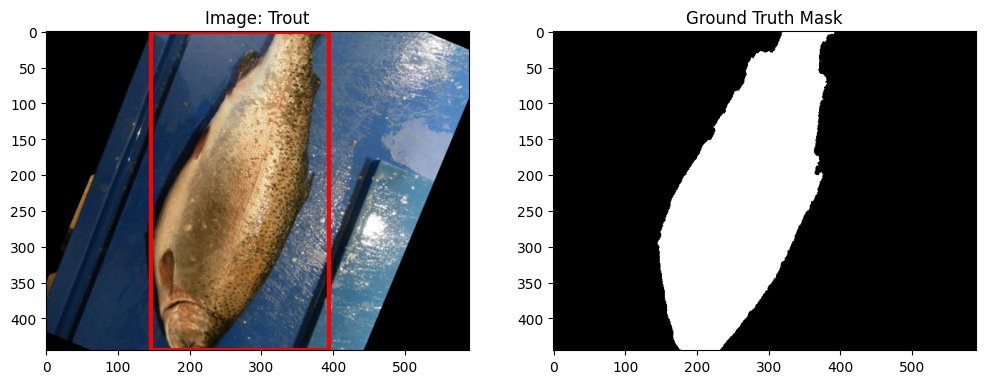

In [ ]:
# Pick a random image
sample = df[df['has_fish'] == True].sample(1).iloc[0]

# Load data
img = cv2.imread(sample['image_path'])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(sample['mask_path'], cv2.IMREAD_GRAYSCALE)

xmin, ymin, xmax, ymax = sample['xmin'], sample['ymin'], sample['xmax'], sample['ymax']

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Image with Box
ax[0].imshow(img)
rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                     linewidth=3, edgecolor='red', facecolor='none')
ax[0].add_patch(rect)
ax[0].set_title(f"Image: {sample['species']}")

# Mask
ax[1].imshow(mask, cmap='gray')
ax[1].set_title("Ground Truth Mask")

plt.show()

# Preprocess dataset
- Encode dataset
- Split Data
- convert Box to YOLO format

In [ ]:
import os
import shutil
import yaml
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm  # Progress bar

# 1. Define YOLO Directory Structure
output_dir = "yolo_dataset"
images_dir = os.path.join(output_dir, "images")
labels_dir = os.path.join(output_dir, "labels")

# Create folders: images/train, images/test, labels/train, labels/test
for split in ['train', 'test']:
    os.makedirs(os.path.join(images_dir, split), exist_ok=True)
    os.makedirs(os.path.join(labels_dir, split), exist_ok=True)

# 2. Encode Classes (String -> Int)
classes = df['species'].unique().tolist()
class_map = {name: i for i, name in enumerate(classes)}

print("Class mapping:", class_map)

# 3. Split Data (80% Train, 20% Test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['species'])

# Function to convert Box to YOLO format
def process_dataset(dataframe, split_name):
    print(f"Processing {split_name} data...")

    for index, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
        # Skip if no fish (optional, but YOLO can train on background images too)
        #if not row['has_fish']:
           # continue

        # Source Paths
        img_src = row['image_path']
        filename = os.path.basename(img_src)
        name_only = os.path.splitext(filename)[0]

        # Read Image Dimensions
        img = cv2.imread(img_src)
        h, w, _ = img.shape

        # Calculate YOLO Coordinates (Normalized 0-1)
        # formula: center_x, center_y, width, height
        dw = 1. / w
        dh = 1. / h

        x_center = (row['xmin'] + row['xmax']) / 2.0
        y_center = (row['ymin'] + row['ymax']) / 2.0
        width = row['xmax'] - row['xmin']
        height = row['ymax'] - row['ymin']

        x_center *= dw
        width *= dw
        y_center *= dh
        height *= dh

        # Write Label File (.txt)
        class_id = class_map[row['species']]
        label_path = os.path.join(labels_dir, split_name, name_only + ".txt")

        with open(label_path, 'w') as f:
            # Format: class x_center y_center width height
            f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

        # Copy Image File
        dst_img_path = os.path.join(images_dir, split_name, filename)
        shutil.copy(img_src, dst_img_path)

# Run conversion
process_dataset(train_df, 'train')
process_dataset(test_df, 'test')


Class mapping: {'Hourse Mackerel': 0, 'Black Sea Sprat': 1, 'Sea Bass': 2, 'Red Mullet': 3, 'Trout': 4, 'Striped Red Mullet': 5, 'Shrimp': 6, 'Gilt-Head Bream': 7, 'Red Sea Bream': 8}
Processing train data...


  0%|          | 0/7200 [00:00<?, ?it/s]

Processing test data...


  0%|          | 0/1800 [00:00<?, ?it/s]

In [ ]:
data_yaml = {
    'path': os.path.abspath(output_dir),  # Dataset root dir
    'train': 'images/train',
    'val': 'images/test',
    'nc': len(classes),           # Number of classes
    'names': classes              # Class names
}

# Write the file
with open(os.path.join(output_dir, 'data.yaml'), 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

print("data.yaml created successfully.")

data.yaml created successfully.


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.4 MB/s eta 0:00:00


## Custom Model

In [ ]:
yaml_content = """
# Ultralytics YOLOv8n Custom Configuration
nc: 80
scales:
  n: [0.33, 0.25, 1024]

backbone:
  - [-1, 1, Conv, [64, 3, 2]]
  - [-1, 1, Conv, [128, 3, 2]]
  - [-1, 3, C2f, [128, True]]
  - [-1, 1, Conv, [256, 3, 2]]
  - [-1, 6, C2f, [256, True]]
  - [-1, 1, Conv, [512, 3, 2]]
  - [-1, 6, C2f, [512, True]]
  - [-1, 1, Conv, [1024, 3, 2]]
  - [-1, 6, C2f, [1024, True]]  # Modified to 6 repeats
  - [-1, 1, SPPF, [1024, 5]]

head:
  - [-1, 1, nn.Upsample, [None, 2, 'nearest']]
  - [[-1, 6], 1, Concat, [1]]
  - [-1, 3, C2f, [512]]
  - [-1, 1, nn.Upsample, [None, 2, 'nearest']]
  - [[-1, 4], 1, Concat, [1]]
  - [-1, 3, C2f, [256]]
  - [-1, 1, Conv, [256, 3, 2]]
  - [[-1, 12], 1, Concat, [1]]
  - [-1, 3, C2f, [512]]
  - [-1, 1, Conv, [512, 3, 2]]
  - [[-1, 9], 1, Concat, [1]]
  - [-1, 3, C2f, [1024]]
  - [[15, 18, 21], 1, Detect, [nc]]
"""

# This writes the file to your disk
with open("custom_yolov8n.yaml", "w") as f:
    f.write(yaml_content)

print("Success! 'custom_yolov8n.yaml' has been created.")

Success! 'custom_yolov8n.yaml' has been created.


In [ ]:
from ultralytics import YOLO

# 1. Load the Custom Model
model = YOLO('custom_yolov8n.yaml')

# Transfer weights from the standard YOLOv8n model.
model.load('yolov8n.pt')



# 2. Train the Model
results = model.train(
    data=os.path.join('yolo_dataset', 'data.yaml'),
    epochs=20,
    imgsz=640,
    batch=16,
    name='custom_fish_model'
)


# 3. Validate & Print Results
metrics = model.val(data=os.path.join('yolo_dataset', 'data.yaml'))

print("\n" + "="*30)
print("--- Custom Model mAP Results ---")
print(f"mAP@50:    {metrics.box.map50:.3f}")
print(f"mAP@50-95: {metrics.box.map:.3f}")
print("="*30 + "\n")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Transferred 354/367 items from pretrained weights
Ultralytics 8.3.230 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=

In [ ]:
metrics = model.val(data=os.path.join("yolo_dataset", "data.yaml"))

print("--- Metrics ---")
print(f"Precision:      {metrics.box.mp:.3f}")
print(f"Recall:         {metrics.box.mr:.3f}")
print(f"mAP@50:         {metrics.box.map50:.3f}")
print(f"mAP@50-95:      {metrics.box.map:.3f}")

# Inference time (ms per image)
inference_time = metrics.speed['inference']
print(f"Inference Time: {inference_time:.3f} ms")


Ultralytics 8.3.230 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2985.1±1233.1 MB/s, size: 357.7 KB)
val: Scanning /content/yolo_dataset/labels/test.cache... 859 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 859/859 1.8Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 54/54 2.7it/s 19.8s
                   all        859        859      0.991      0.994       0.99      0.923
       Hourse Mackerel         88         88      0.992          1      0.995      0.954
       Black Sea Sprat         90         90      0.964      0.978      0.974      0.904
              Sea Bass         92         92          1      0.991      0.995      0.924
            Red Mullet         90         90      0.999          1      0.995      0.943
                 Trout        103        103      0.997          1      0.995      0.972
    Striped Red Mullet         89 

✅ Found latest run: runs/detect/custom_fish_model

--- Confusion Matrix ---


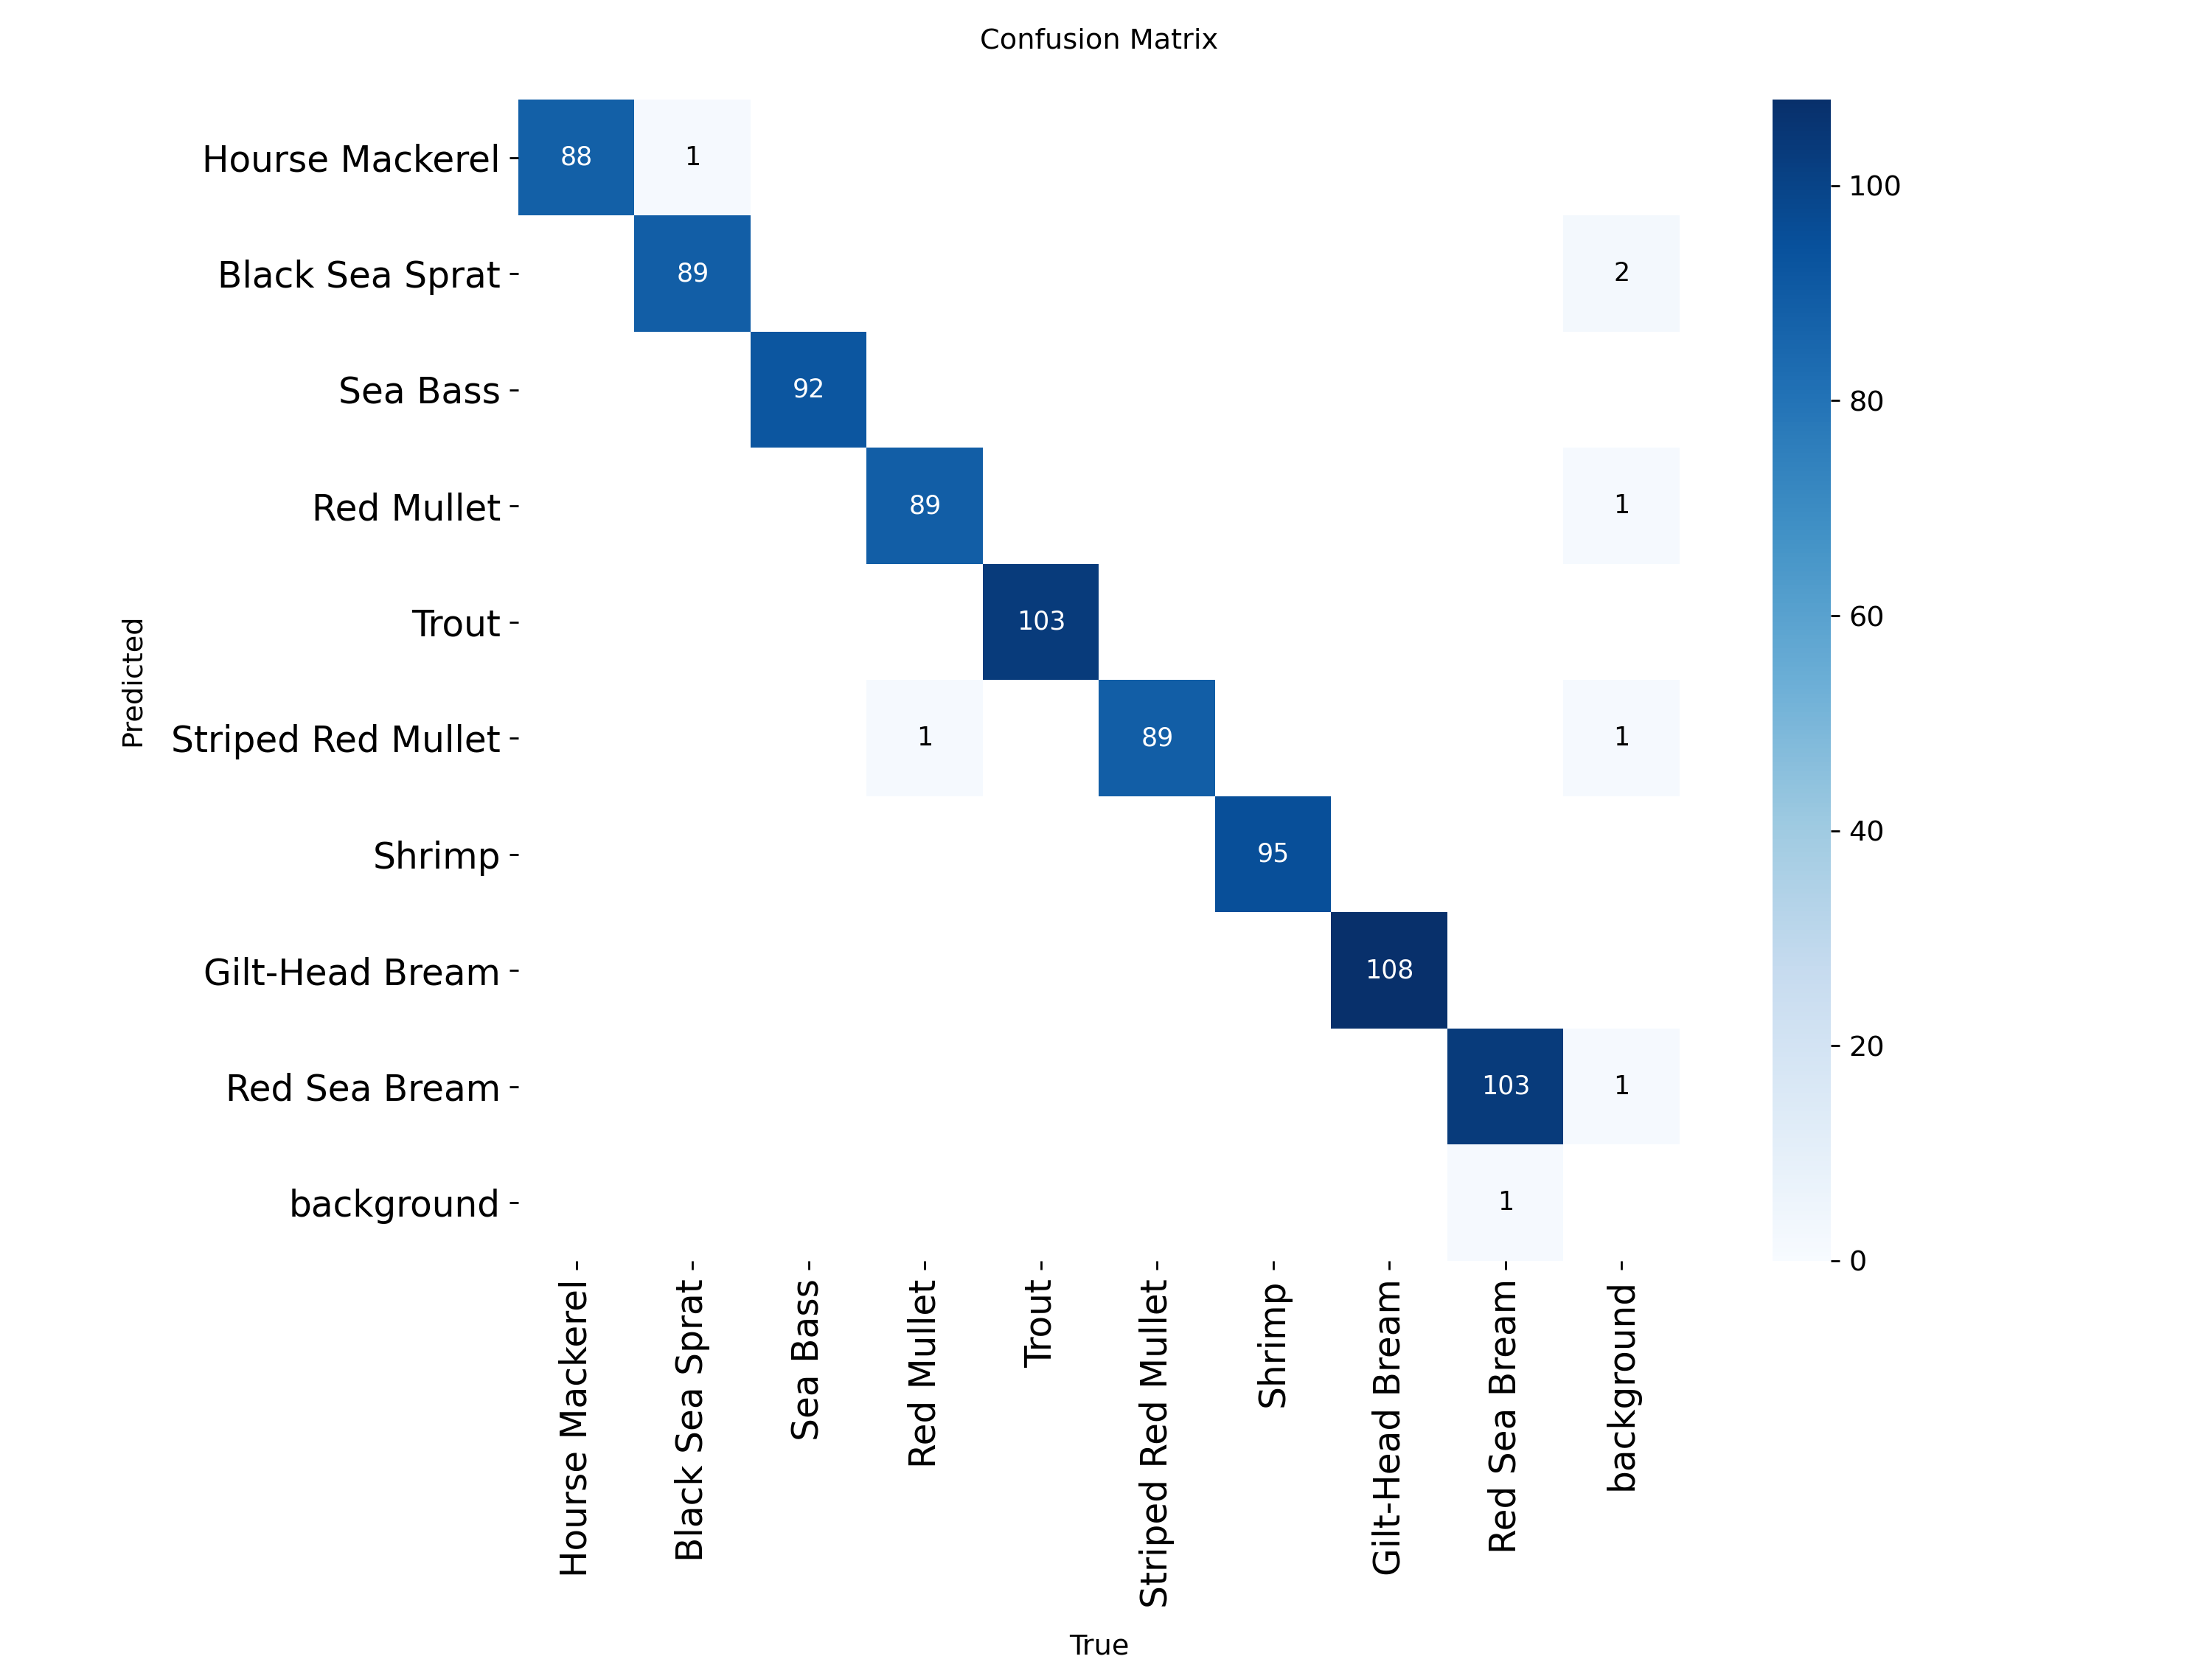


--- Training Results (Loss & mAP) ---


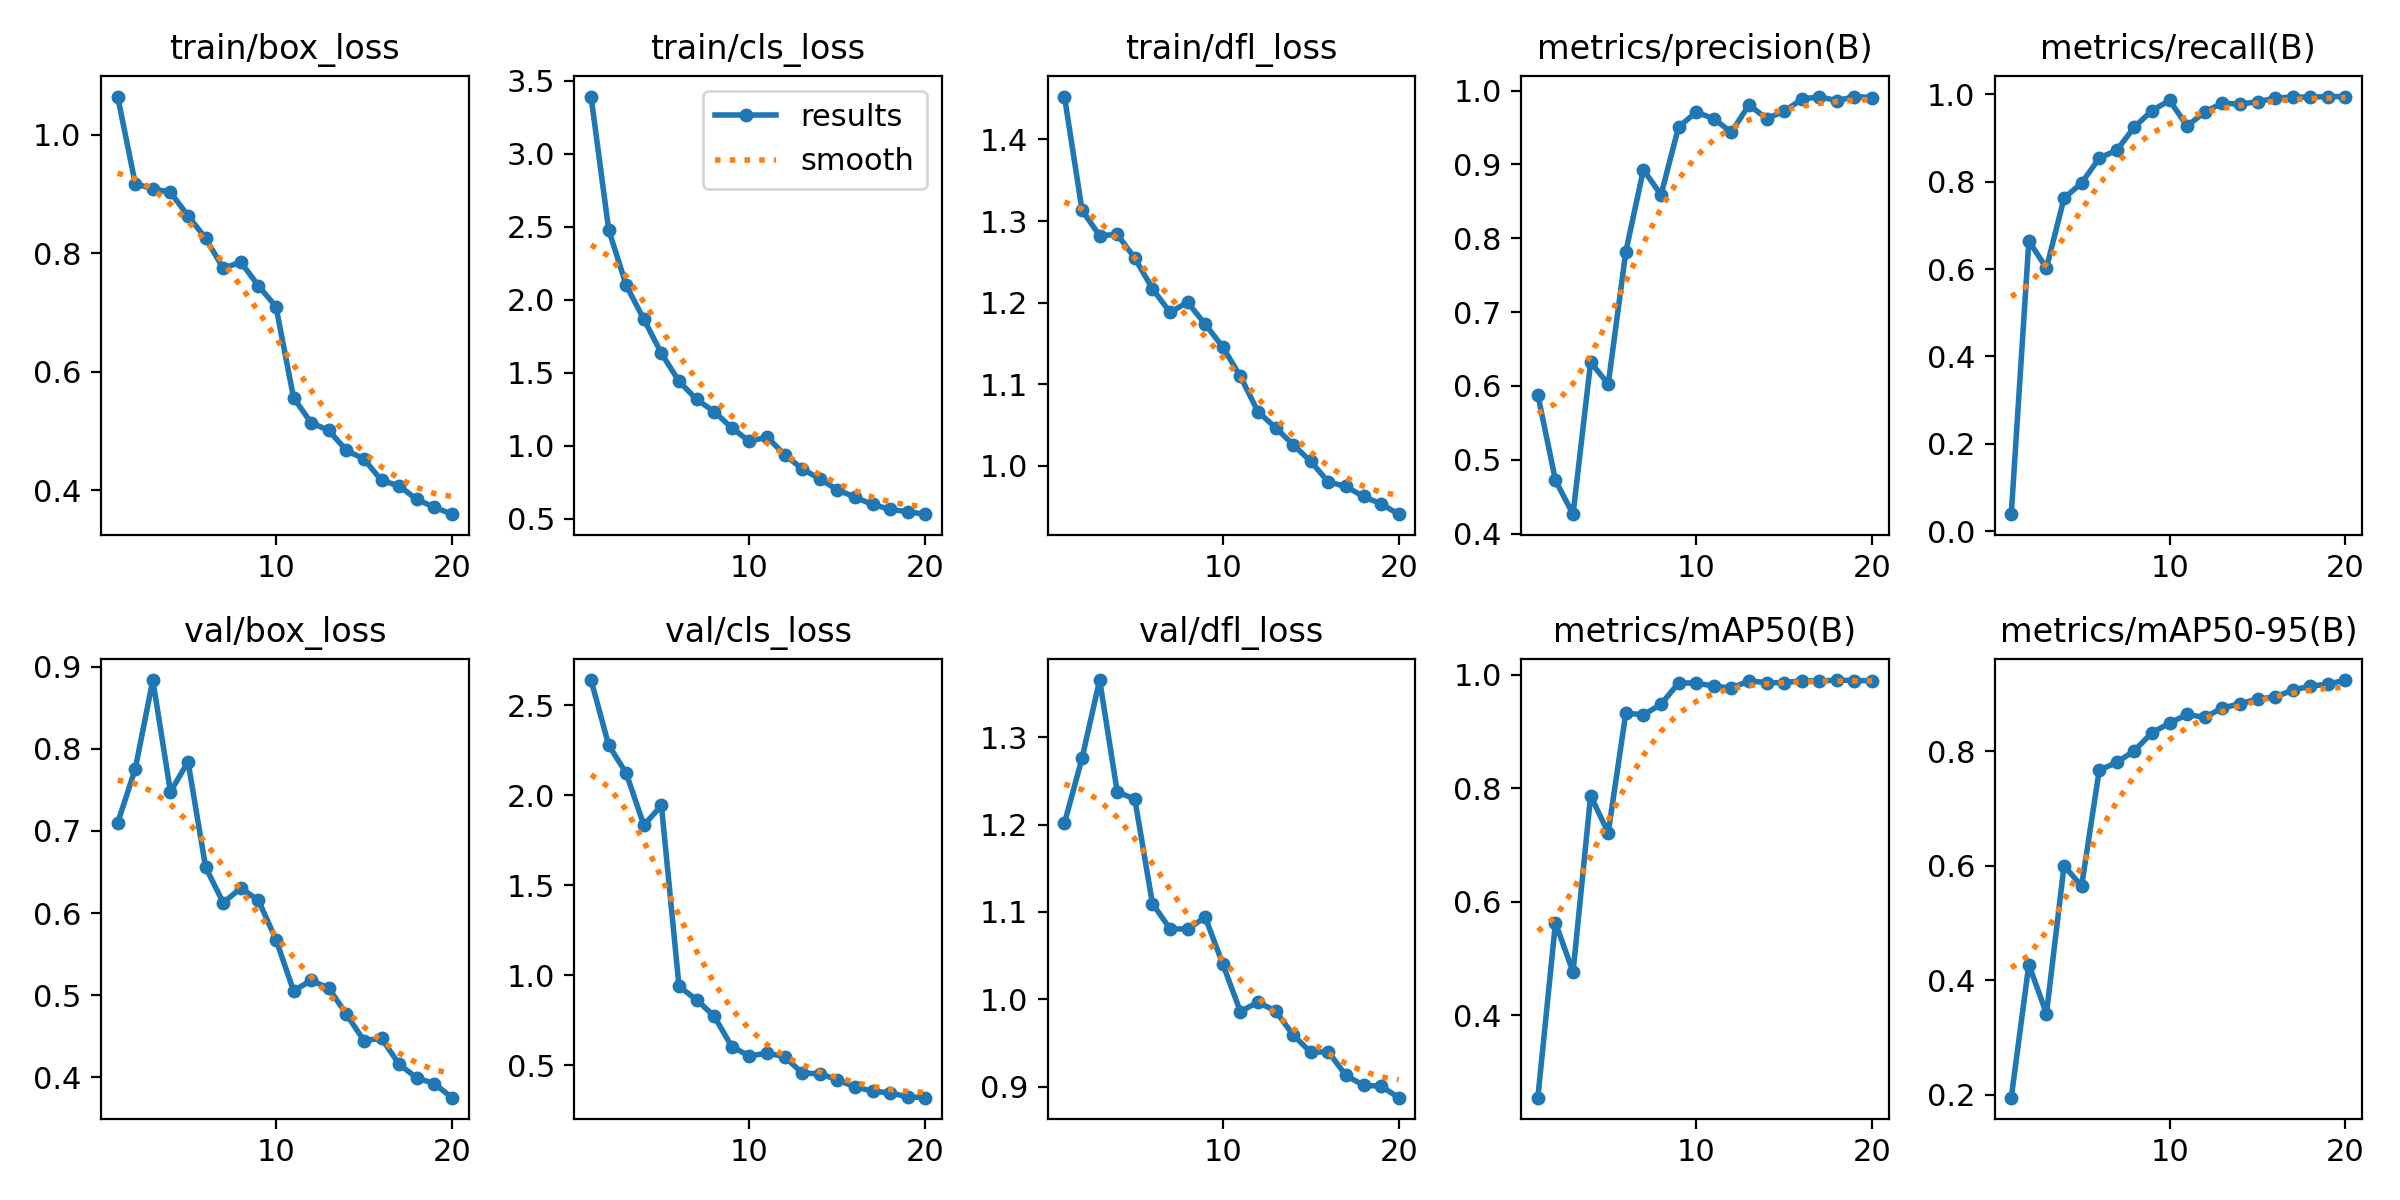

In [ ]:
import os
import glob
from IPython.display import Image, display

# 1. Define the base name
base_name = 'custom_fish_model'

# 2. Find the latest run directory automatically
search_pattern = os.path.join("runs", "detect", f"{base_name}*")
all_runs = glob.glob(search_pattern)

if all_runs:
    # Find the folder with the most recent timestamp
    latest_run = max(all_runs, key=os.path.getmtime)
    print(f"✅ Found latest run: {latest_run}")

    # 3. Display the plots
    print("\n--- Confusion Matrix ---")
    display(Image(filename=os.path.join(latest_run, 'confusion_matrix.png')))


    print("\n--- Training Results (Loss & mAP) ---")
    display(Image(filename=os.path.join(latest_run, 'results.png')))


image 1/1 /content/yolo_dataset/images/test/00422.png: 512x640 1 Gilt-Head Bream, 14.5ms
Speed: 2.7ms preprocess, 14.5ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/yolo_dataset/images/test/00422.png: 512x640 1 Gilt-Head Bream, 5.9ms
Speed: 2.0ms preprocess, 5.9ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)
Inference time: 18.35 ms


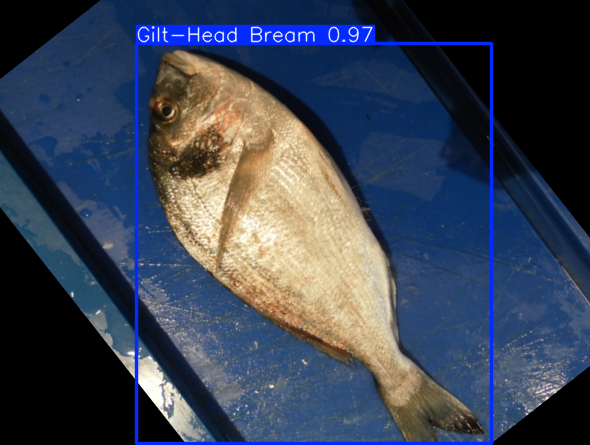

In [ ]:
import time

test_img_path = os.path.join(images_dir, 'test', os.listdir(os.path.join(images_dir, 'test'))[0])

# Warm-up
model.predict(test_img_path)

# Measure inference time
start = time.time()
results = model.predict(test_img_path)
end = time.time()

inference_time = (end - start) * 1000   # convert to ms
print(f"Inference time: {inference_time:.2f} ms")

# Display result
for result in results:
    result.show()



image 1/1 /content/yolo_dataset/images/test/00755.png: 512x640 1 Striped Red Mullet, 6.2ms
Speed: 2.1ms preprocess, 6.2ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/yolo_dataset/images/test/00755.png: 512x640 1 Striped Red Mullet, 5.9ms
Speed: 2.1ms preprocess, 5.9ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)
Inference time: 21.88 ms


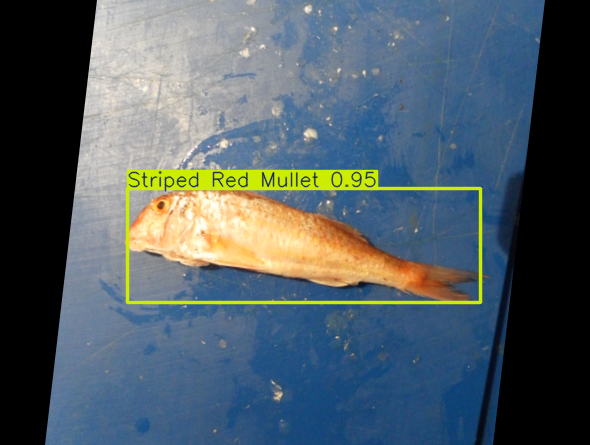

In [ ]:
test_img_path = os.path.join(images_dir, 'test', os.listdir(os.path.join(images_dir, 'test'))[500])

# Warm-up
model.predict(test_img_path)

# Measure inference time
start = time.time()
results = model.predict(test_img_path)
end = time.time()

inference_time = (end - start) * 1000   # convert to ms
print(f"Inference time: {inference_time:.2f} ms")

# Display result
for result in results:
    result.show()
